In [81]:
import pandas as pd
import numpy as np
import math
import scipy.io
import glob, os
from pyaldata import *
import matplotlib.pyplot as plt

        

In [104]:
os.chdir("/home/cf620/Downloads/Mouse data/")

list_of_data = glob.glob("*ss.mat")

In [130]:
list_of_data

['js2p0_tbytSpkHandJsTrj10msBin_WR39_100219_ss.mat',
 'js2p0_tbytSpkHandJsTrj10msBin_WR44_031020_ss.mat',
 'js2p0_tbytSpkHandJsTrj10msBin_WR40_081919_ss.mat',
 'js2p0_tbytSpkHandJsTrj10msBin_WR38_052419_ss.mat',
 'js2p0_tbytSpkHandJsTrj10msBin_WR38_052219_ss.mat',
 'js2p0_tbytSpkHandJsTrj10msBin_WR40_082019_ss.mat']

In [131]:
data_file = list_of_data[-1]

In [132]:
df = mat2dataframe(data_file, True, 'ss')

df['bin_size'] = 0.02
df['unitTimeBCtx'] = [np.nan_to_num(data.T.toarray()) for data in df['unitTimeBCtx']]
df['unitTimeBStr'] = [np.nan_to_num(data.T.toarray()) for data in df['unitTimeBStr']]
df['trial_id'] = df.index

In [133]:
df = rename_fields(df,{'unitTimeBCtx':'M1_spikes','unitTimeBStr':'striatum_spikes',
                'hTrjBfull':'pos_full',
                'hTrjB':'pos',
                'hVelB':'vel',
                })

In [134]:
df['reach_start'] = 50

In [135]:
df = restrict_to_interval(df, start_point_name='reach_start', rel_start=-5, rel_end=25)


In [136]:
df = transform_signal(df, "M1_spikes", 'sqrt')
df = transform_signal(df, "striatum_spikes", 'sqrt')
df = transform_signal(df, "M1_spikes", 'zero_normalize')
df = transform_signal(df, "striatum_spikes", 'zero_normalize')
df = merge_signals(df, ["M1_spikes", "striatum_spikes"], "both_spikes")
df = add_firing_rates(df, 'smooth')

df = select_trials(df, "trialType == 'sp'")

In [137]:
df['pos'] = [df.loc[i,'pos'].T for i in df.index]
df['vel'] = [df.loc[i,'vel'].T for i in df.index]

In [138]:
df['labels'] = df['blNumber']

for i in df.index:
    if df.loc[i,'blNumber'] ==1 or df.loc[i,'blNumber'] ==5:
        df.loc[i, 'labels'] = 1
    elif df.loc[i,'blNumber'] ==2 or df.loc[i,'blNumber'] ==6:
        df.loc[i, 'labels'] = 2
    elif df.loc[i,'blNumber'] ==3 or df.loc[i,'blNumber'] ==7:
        df.loc[i, 'labels'] = 3
    elif df.loc[i,'blNumber'] ==4 or df.loc[i,'blNumber'] ==8:
        df.loc[i, 'labels'] = 4




# Remove trials with empty trajectories and larger trajectories
empty_traj = []
for i in df.index:
    traj = np.array(df.loc[i,'pos'])
    if not traj.any():
        empty_traj.append(i)
        
empty_traj = np.array(empty_traj)

df = df.drop(empty_traj)

large_traj = []
for i in df.index:
    traj = np.array(df.loc[i,'pos'])
    if traj.shape[0]>150:
        large_traj.append(i)
        
large_traj = np.array(large_traj)

df = df.drop(large_traj)


df =df.reset_index()

if 'spkTimeBlaserI' in df.columns:
    laser_on = []
    for i in df.index:
        if sum(df.loc[i, 'spkTimeBlaserI'])>1:
            laser_on.append(i)
    laser_on = np.array(laser_on)
    df = df.drop(laser_on)
    df =df.reset_index()
# remove trials with laser-ON

    df = df.drop(columns='spkTimeBlaserI')

df = df.drop(columns=['pos','vel'])

In [139]:
neural_data = df[['trialType', 'M1_rates', 'striatum_rates', 'labels','trial_id']]

In [140]:
td_avg = trial_average(neural_data, "labels")

/home/cf620/git/PyalData/pyaldata/tools.py:156: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  av_df = trial_data.mean()


In [141]:
td_avg

,labels,M1_rates,striatum_rates,trialType
1,1.0,"[[0.0, 5.130218, 5.0457587, 2.200988, 0.639344...","[[0.0, 1.875267, 0.0022388955, 0.0, 3.598644, ...",sp
2,2.0,"[[0.0, 4.2231803, 1.5081178, 6.0229163, 0.0, 1...","[[0.006657759, 1.5297506, 2.2736578, 0.0, 5.23...",sp
3,3.0,"[[0.0, 10.6429615, 1.2128823, 2.4196982, 0.0, ...","[[0.86770016, 2.5653877, 0.105505355, 0.0, 5.4...",sp
4,4.0,"[[0.0, 11.568193, 1.3332707, 2.561233, 0.93994...","[[0.043299995, 1.5989134, 1.6806935, 2.2975757...",sp


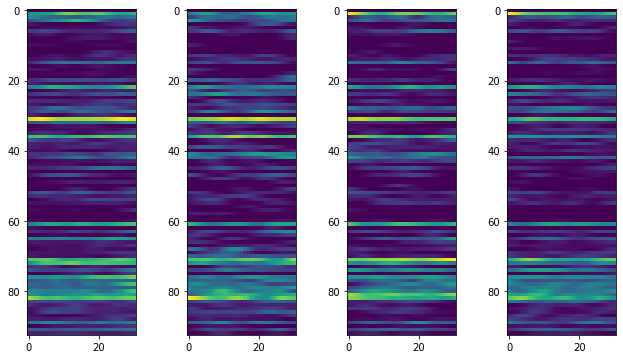

In [142]:
fig, axs= plt.subplots(1, 4, figsize=(11, 6))


for i in td_avg.index:
    axs[i-1].imshow(td_avg.loc[i,'M1_rates'].T)





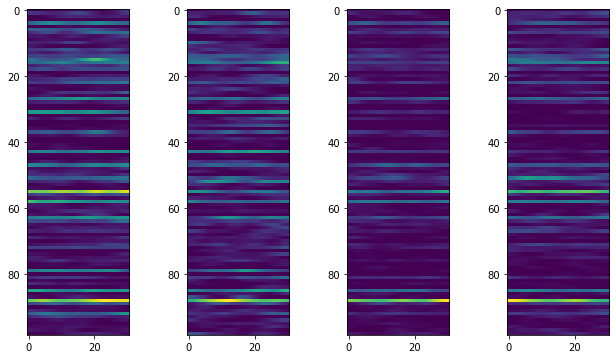

In [143]:
fig, axs= plt.subplots(1, 4, figsize=(11, 6))


for i in td_avg.index:
    axs[i-1].imshow(td_avg.loc[i,'striatum_rates'].T)